# Tutorial

This is a tutorial for the `momi` package. You can run the ipython
notebook that created this tutorial at `examples/tutorial.ipynb`.

To get started, import the `momi` package: 

In [1]:
import momi

Some `momi` operations can take awhile complete, so it is useful to turn
on status monitoring messages to check that everything is running
normally. Here, we output logging messages to the file `tutorial.log`.
See the [logging](https://docs.python.org/3/library/logging.html)
module for more details. 

In [2]:
import logging
logging.basicConfig(level=logging.INFO, 
                    filename="tutorial.log")

## Constructing a demographic history 

We will construct a demographic model loosely based on human history. To
start, we need to specify `N_e`, which is the *diploid* size of each population
unless specified otherwise, and `gen_time`, the amount of
time per generation.

We will measure time in years; the human generation time is
approximately `gen_time=29` years per generation. The human effective
population size is typically measured as $1.2 \times 10^{4}$ so we set
`N_e=1.2e4`.

In [3]:
model = momi.DemographicModel(N_e=1.2e4, gen_time=29,
                              muts_per_gen=1.25e-8)

We now specify the sampled ("leaf") populations of our demography. We
specify three populations: YRI, CHB, and NEA. YRI and CHB are
present-day populations at $t=0$, while NEA is an archaic population
from $t=50,000$ years ago. We set YRI and NEA to have the default
population sizes, and set CHB to have a size of $N=100,000$ growing at
rate $.0005$ per year.

In [4]:
# add YRI leaf at t=0 and default_N
model.add_leaf("YRI")
# add  CHB leaf at t=0, N=1e5, growing at rate 5e-4 per unit time (year)
model.add_leaf("CHB", N=1e5, g=5e-4)
# add NEA leaf at 50kya
model.add_leaf("NEA", t=5e4)

Demographic events are added to the model by the methods `set_size()`
and `move_lineages()`. `set_size()` is used to change population size
and growth rate, while `move_lineages()` is used for population split
and admixture events.

In [5]:
# stop CHB growth at 10kya
model.set_size("CHB", g=0, t=1e4)

# at 45kya CHB receive a 3% pulse from GhostNea
model.move_lineages("CHB", "GhostNea", t=4.5e4, p=.03)
# at 55kya GhostNea joins onto NEA
model.move_lineages("GhostNea", "NEA", t=5.5e4)

# at 80 kya CHB goes thru bottleneck
model.set_size("CHB", N=100, t=8e4)
# at 85 kya CHB joins onto YRI
model.move_lineages("CHB", "YRI", t=8.5e4)

# at 500 kya YRI joins onto NEA
model.move_lineages("YRI", "NEA", t=5e5)

If you are familiar with the software
[ms](http://home.uchicago.edu/rhudson1/source/mksamples.html),
`set_size()` is analogous to the flags "-en" and "-eg", while
`move_lineages()` is analogous to the flags "-ej" and "-es". If you are
familiar with the package
[msprime](https://msprime.readthedocs.io/en/stable/), then
`set_size()` is analogous to `msprime.PopulationParametersChange`, while
`move_lineages()` is analogous to `msprime.MassMigration`.

Note that events can involve other populations aside from the 3 sampled
populations YRI, CHB, and NEA. Unsampled populations are also known as
"ghost populations". In this example, CHB receives a small amount of
admixture from a population "GhostNea", which splits off from NEA at an
earlier date. 

## Plotting a demography 

`momi` relies on `matplotlib` for plotting.
In a notebook, first call `%matplotlib inline`
to enable matplotlib, then you can
use `momi.DemographyPlot` to create a plot of the demographic model.

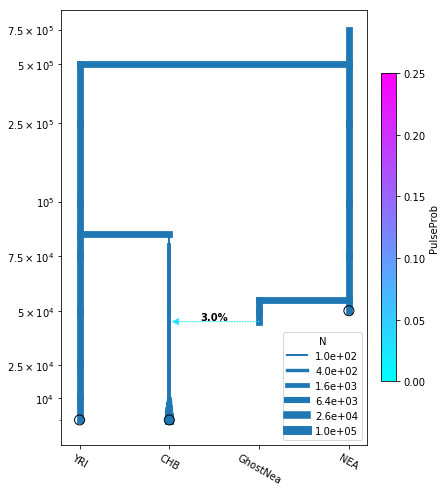

In [6]:
%matplotlib inline

yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5]

fig = momi.DemographyPlot(
    model, ["YRI", "CHB", "GhostNea", "NEA"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5, pulse_color_bounds=(0,.25))

Note the user needs to specify the order of all populations (including
ghost populations) along the x-axis.

The argument `linthreshy` is useful for visualizing demographic events
at different scales. In our example, the split time of NEA is far above
the other events. Times below `linthreshy` are plotted on a linear
scale, while times above it are plotted on a log scale.



## Reading and simulating data 

In this section we demonstrate how to read in data from a VCF file.

Before we can read in a dataset we first need to create one. So we start
by demonstrating how to simulate a VCF from our demography, then we read
it in. 

### Simulating data 

We simulate a dataset of diploid individuals,
with 20 "chromosomes" of length 50Kb, with a recombination
rate of 1.25e-8. `momi` uses `msprime` under the hood to do this.

The datasets are saved in `data/$chrom.vcf.gz`. Accompanying tabix and bed files are also created.

In [7]:
recoms_per_gen = 1.25e-8
bases_per_locus = int(5e5)
n_loci = 20
ploidy = 2

# n_alleles per population (n_individuals = n_alleles / ploidy)
sampled_n_dict = {"NEA":2, "YRI":4, "CHB":4}

# create data directory if it doesn't exist
import os
os.makedirs("data", exist_ok=True)

# simulate 20 "chromosomes", saving each in a separate vcf file
for chrom in range(1, n_loci+1):
      model.simulate_vcf(
            f"data/{chrom}",
            recoms_per_gen=recoms_per_gen,
            length=bases_per_locus,
            chrom_name=f"chr{chrom}",
            ploidy=ploidy,
            random_seed=1234+chrom,
            sampled_n_dict=sampled_n_dict,
            force=True)

The datasets are saved in `data/$chrom.vcf.gz`. Accompanying tabix and bed files are also created.

In [8]:
!ls data/

10.bed	       14.bed	      18.bed	     2.bed	   6.bed
10.vcf.gz      14.vcf.gz      18.vcf.gz      2.vcf.gz	   6.vcf.gz
10.vcf.gz.tbi  14.vcf.gz.tbi  18.vcf.gz.tbi  2.vcf.gz.tbi  6.vcf.gz.tbi
11.bed	       15.bed	      19.bed	     3.bed	   7.bed
11.vcf.gz      15.vcf.gz      19.vcf.gz      3.vcf.gz	   7.vcf.gz
11.vcf.gz.tbi  15.vcf.gz.tbi  19.vcf.gz.tbi  3.vcf.gz.tbi  7.vcf.gz.tbi
12.bed	       16.bed	      1.bed	     4.bed	   8.bed
12.vcf.gz      16.vcf.gz      1.vcf.gz	     4.vcf.gz	   8.vcf.gz
12.vcf.gz.tbi  16.vcf.gz.tbi  1.vcf.gz.tbi   4.vcf.gz.tbi  8.vcf.gz.tbi
13.bed	       17.bed	      20.bed	     5.bed	   9.bed
13.vcf.gz      17.vcf.gz      20.vcf.gz      5.vcf.gz	   9.vcf.gz
13.vcf.gz.tbi  17.vcf.gz.tbi  20.vcf.gz.tbi  5.vcf.gz.tbi  9.vcf.gz.tbi


### Read in data from vcf 

First we need to create a mapping from individuals to populations.
We save this mapping to a text file whose first column
is for individuals and second column is for populations.

In [9]:
# a dict mapping samples to populations
ind2pop = {}
for pop, n in sampled_n_dict.items():
    for i in range(int(n / ploidy)):
        # in the vcf, samples are named like YRI_0, YRI_1, CHB_0, etc
        ind2pop["{}_{}".format(pop, i)] = pop

with open("ind2pop.txt", "w") as f:
    for i, p in ind2pop.items():
        print(i, p, sep="\t", file=f)

In [10]:
!cat ind2pop.txt

NEA_0	NEA
YRI_0	YRI
YRI_1	YRI
CHB_0	CHB
CHB_1	CHB


From the command line, use `python -m momi.vcf_allele_counts` to
compute allele counts for each VCF.

The `--bed` flag is used to read in a BED file specifying which
regions of the VCF to read. It is also used to determine
the size of the data in bases. It is very important not
to use the same BED file across multiple VCF files --
the BED files should be non-overlapping.
Otherwise regions will be double-counted when
computing the length of the data!

By default ancestral alleles are read from the INFO AA field
(SNPs missing this field are skipped) but this behavior can be
changed by setting the flags `--no_aa` or `--outgroup`.

Use the `--help` flag to see more command line options,
and the Python API for `momi.SnpAlleleCounts.read_vcf`
for more details.

Below we read in each VCF file, compute the allele counts,
and store the result in `data/$chrom.snpAlleleCounts.gz`

In [12]:
%%sh
for chrom in `seq 1 20`;
do
    python -m momi.vcf_allele_counts \
           data/$chrom.vcf.gz ind2pop.txt \
           data/$chrom.snpAlleleCounts.gz \
           --bed data/$chrom.bed
done

Use `python -m momi.extract_sfs` to combine the allele counts across
multiple files and extract the SFS. It also splits the SFS
into a number of equally sized blocks (100 in the example below),
for jackknifing and bootstrapping later.

Below we save the resulting SFS into `data/sfs.gz`.

In [13]:
%%sh
python -m momi.extract_sfs data/sfs.gz 100 data/*.snpAlleleCounts.gz

As an alternative to calling `vcf_allele_counts` and `extract_sfs` from the command line,
equivalent functions can be called directly from Python.
For details see the API documentation for `momi.SnpAlleleCounts.read_vcf()` and `momi.SnpAlleleCounts.extract_sfs()`.

From within Python, read in the resulting SFS with
`momi.site_freq_spectrum.load`.

In [14]:
sfs = momi.site_freq_spectrum.load("data/sfs.gz")

## Inference 

In this section we will infer a demography for the data we simulated.
We will start by fitting a sub-demography on CHB and YRI, and then
iteratively build on this model, by adding the NEA population and also
additional parameters and events. 

### An initial model for YRI and CHB 

We start by creating a `DemographicModel` object as before: 

In [15]:
model2 = momi.DemographicModel(N_e=1.2e4, gen_time=29,
                               muts_per_gen=1.25e-8)

Above we define parameters for the CHB size, the CHB growth rate,
and the CHB-YRI split time.
The size and split time were initialized with random values, while
we initialized the growth rate as 0.
We also provide some optional lower and upper bounds to these parameters.

Demographic events can be added similarly as before. 
Parameters are specified by name (string), 
while constants are specified as numbers (float).

Note the `muts_per_gen` keyword is optional, but helpful:
if the mutation rate is provided then `momi` can use it to fit the
total number of SNPs in the dataset.
Otherwise =momi= will not be able to use
this information, potentially losing some power.

We provide the model with a dataset by calling `set_data()`: 

In [16]:
model2.set_data(sfs) 

Parameters can be added to the model via the methods
`add_size_param()`, `add_growth_param()`, `add_time_param()`,
and `add_pulse_param()`. 

In [17]:
model2.add_size_param("n_chb")
model2.add_growth_param("g_chb", 0, lower=-1e-3, upper=1e-3)
model2.add_time_param("t_chb_yri", lower=1e4) 

Above we define parameters for the CHB size, the CHB growth rate,
and the CHB-YRI split time.
The size and split time were initialized with random values, while
we initialized the growth rate as 0.
We also provide some optional lower and upper bounds to these parameters.

Demographic events can be added similarly as before. 
Parameters are specified by name (string), 
while constants are specified as numbers (float). 

In [18]:
model2.add_leaf("CHB", N="n_chb", g="g_chb")
model2.add_leaf("YRI")
model2.set_size("CHB", t=1e4, g=0)
model2.move_lineages("CHB", "YRI", t="t_chb_yri")

Use the method `optimize()` to search for the MLE.
It accepts parameters similar to `scipy.optimize.minimize`
(it is just a thin wrapper around that function). 

In [19]:
model2.optimize(method="TNC") 

            fun: 0.0015915250272807704
            jac: array([-9.45688615e-07, -3.47775208e-03, -4.80233522e-10])
  kl_divergence: 0.0015915250272807704
 log_likelihood: -33247.62491472155
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 52
            nit: 21
     parameters: ParamsDict({'n_chb': 977112.9962637096, 'g_chb': 0.0007025146644072265, 't_chb_yri': 117686.57260511251})
         status: 1
        success: True
              x: array([1.37923576e+01, 7.02514664e-04, 1.07686573e+05])

The default optimization method is `method="TNC"` (truncated Newton conjugate).
This is very accurate but can be slow for large models; for large models,
`method="L-BFGS-B"` is a good choice.

We can print the inferred parameter values with `get_params()`: 

In [20]:
model2.get_params()

ParamsDict([('n_chb', 977112.9962637096),
            ('g_chb', 0.0007025146644072265),
            ('t_chb_yri', 117686.57260511251)])

and we can plot the inferred demography as before:

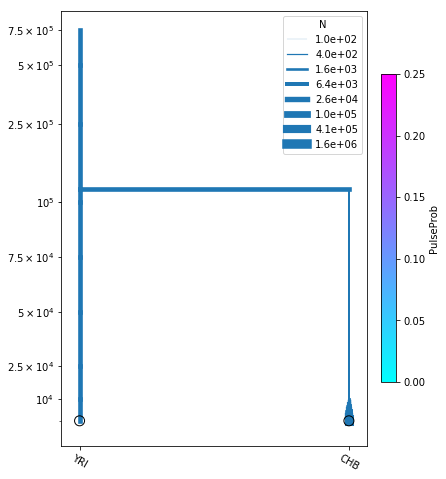

In [21]:
# plot the model
fig = momi.DemographyPlot(model2, ["YRI", "CHB"],
                          figsize=(6,8), linthreshy=1e5,
                          major_yticks=yticks,
                          pulse_color_bounds=(0,.25))

### Adding NEA to the existing model 

Now we add in the NEA population, along with a parameter for its split time
`t_anc`. We use the keyword `lower_constraints` to require that `t_anc > t_chb_yri`. 

In [22]:
model2.add_leaf("NEA", t=5e4)
model2.add_time_param("t_anc", lower=5e4, lower_constraints=["t_chb_yri"])
model2.move_lineages("YRI", "NEA", t="t_anc")

We search for the new MLE and plot the inferred demography: 

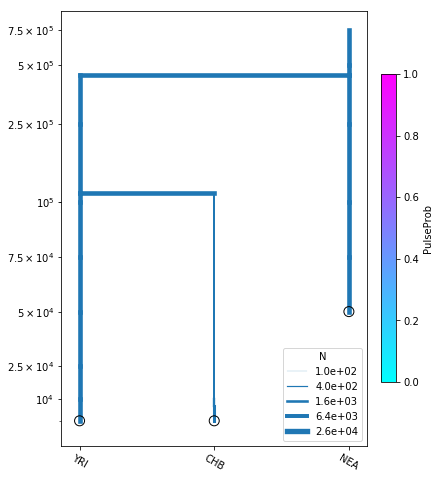

In [23]:
model2.optimize()

fig = momi.DemographyPlot(
    model2, ["YRI", "CHB", "NEA"],
    figsize=(6,8), linthreshy=1e5,
    major_yticks=yticks) 

### Evaluating model fit (ABBA-BABA, sequence divergence) 

The `SfsModelFitStats` class can be used to compute various 
statistics of the SFS and see how well they fit the model.

One such statistic is the `f4()` or "ABBA-BABA" statistic for
detecting introgression. In the absence of admixture it should be 0,
but it is significantly negative for our dataset: 

In [24]:
model_fit_stats = momi.SfsModelFitStats(model2)

print("Computing f4(YRI, CHB, NEA, AncestralAllele)")
f4 = model_fit_stats.f4("YRI", "CHB", "NEA", None)

print("Expected = {}".format(f4.expected))
print("Observed = {}".format(f4.observed))
print("SD = {}".format(f4.sd))
print("Z(Expected-Observed) = {}".format(f4.z_score))

Computing f4(YRI, CHB, NEA, AncestralAllele)
Expected = 1.0408340855860843e-17
Observed = -0.005514202210247513
SD = 0.002658556730985845
Z(Expected-Observed) = -2.0741337380461875


Other statistics such as `f2()` and `f3()` are also available
for evaluating model fit.
The method `all_pairs_ibs()` computes the probability that 
two random alleles are the same, for every pair of populations, and evaluates how well this fits the data: 

,Pop1,Pop2,Expected,Observed,Z
0,CHB,NEA,0.545630,0.552939,1.086249
1,YRI,YRI,0.715978,0.719586,0.768005
2,NEA,NEA,0.715978,0.710339,-0.652327
3,CHB,YRI,0.670542,0.674068,0.587697
4,NEA,YRI,0.545630,0.542869,-0.571180
5,CHB,CHB,0.944628,0.946806,0.337794


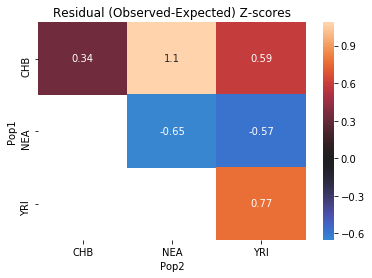

In [25]:
model_fit_stats.all_pairs_ibs()

In addition, the method `SfsModelFitStats.tensor_prod` can be used to
compute very general statistics of the
SFS; see the API help for details.

Note the `SfsModelFitStats` class above has some limitations.
First, it computes goodness-of-fit for the SFS without any missing data;
all entries with missing samples are removed. For datasets
with many individuals and pervasive missingness, this can result
in most or all of the data being removed.

In such cases you can specify to use the SFS restricted
to a smaller number of samples; then all SNPs with at least
that many of non-missing individuals will be used.
For example, 

In [26]:
model_fit_stats = momi.SfsModelFitStats(
    model2, {"YRI": 2, "CHB": 2, "NEA": 2})

will compute statistics for the SFS 
restricted to 2 samples per population.

The second limitation of `SfsModelFitStats` is that it
ignores the mutation rate -- it only fits the SFS normalized
to be a probability distribution.
To evaluate the total number of mutations in the data,
e.g. to fit the mutation rate, you can use the method
`DemographicModel.fit_within_pop_diversity()`,
which computes the within-population nucleotide
diversity, i.e. the heterozygosity of a random
individual from that population: 

In [27]:
model2.fit_within_pop_diversity()

,Pop,EstMutRate,JackknifeSD,JackknifeZscore
0,CHB,1.244766e-08,1.508730e-09,-0.034690
1,YRI,1.279271e-08,2.145191e-10,1.364486
2,NEA,1.321458e-08,3.943437e-10,1.812083


This method returns a dataframe giving estimates for the mutation rate.
Note that there is an estimate for each population -- these estimates
are non-independent estimates for the same value, just computed
in different ways (by computing the expected to observed heterozygosity
for each population separately). These estimates
account for missingness in the data; it is fine to use it
on datasets with large amounts of missingness.

Since we initialized our model with `muts_per_gen=1.25e-8`,
the method also returns a Z-value for the residuals of the estimated
mutation rates.

### Build a new model adding NEA->CHB 

Now we create a new `DemographicModel`,
by copying the previous model and adding a NEA->CHB
migration arrow. 

In [28]:
add_pulse_model = model2.copy()
add_pulse_model.add_pulse_param("p_pulse", upper=.25)
add_pulse_model.add_time_param(
    "t_pulse", upper_constraints=["t_chb_yri"])

add_pulse_model.move_lineages(
    "CHB", "GhostNea", t="t_pulse", p="p_pulse")

add_pulse_model.add_time_param(
    "t_ghost", lower=5e4,
    lower_constraints=["t_pulse"], upper_constraints=["t_anc"])
add_pulse_model.move_lineages(
    "GhostNea", "NEA", t="t_ghost")

It turns out this model has local optima, so we demonstrate how to
fit a few independent runs with different starting parameters.

Use `DemographicModel.set_params(parameter_dict)` to set
new parameter values
to start the search from. If a parameter is not specified and
`randomize=True`, a new value will be randomly sampled for it.

In [29]:
results = []
n_runs = 3
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    add_pulse_model.set_params(
        # parameters inherited from model2 are set to their previous values
        model2.get_params(),
        # other parmaeters are set to random initial values
        randomize=True)

    results.append(add_pulse_model.optimize())

# sort results according to log likelihood, pick the best one
best_result = sorted(results, key=lambda r: r.log_likelihood)[0]

add_pulse_model.set_params(best_result.parameters)

Starting run 1 out of 3...
Starting run 2 out of 3...
Starting run 3 out of 3...


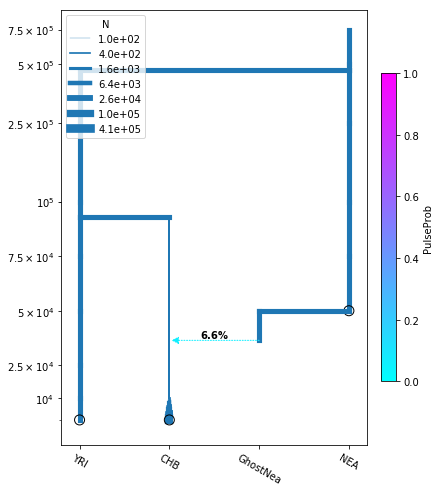

In [30]:
# plot the model
fig = momi.DemographyPlot(
    add_pulse_model, ["YRI", "CHB", "GhostNea", "NEA"],
    linthreshy=1e5, figsize=(6,8),
    major_yticks=yticks)
fig.draw_N_legend(loc="upper left") 

### Bootstrap confidence intervals 

To generate confidence intervals, we can resample blocks of the SFS,
refit the model, and examine the quantiles of the re-inferred parameters.

Below we do this for a very small number of bootstraps and a simplified
fitting procedure. In practice you would want to generate hundreds of bootstraps
on a cluster computer. 

In [31]:
n_bootstraps = 5
# make copies of the original models
submodel_copy = model2.copy()
add_pulse_copy = add_pulse_model.copy()

bootstrap_results = []
for i in range(n_bootstraps):
    print(f"Fitting {i+1}-th bootstrap out of {n_bootstraps}")

    # resample the data
    resampled_sfs = sfs.resample()
    # tell models to use the new dataset
    submodel_copy.set_data(resampled_sfs)
    add_pulse_copy.set_data(resampled_sfs)

    # choose new random parameters for submodel, optimize
    submodel_copy.set_params(randomize=True)
    submodel_copy.optimize()
    # initialize parameters from submodel, randomizing the new parameters
    add_pulse_copy.set_params(submodel_copy.get_params(),
                              randomize=True)
    add_pulse_copy.optimize()

    bootstrap_results.append(add_pulse_copy.get_params())

Fitting 1-th bootstrap out of 5
Fitting 2-th bootstrap out of 5
Fitting 3-th bootstrap out of 5
Fitting 4-th bootstrap out of 5
Fitting 5-th bootstrap out of 5


We can visualize the bootstrap results by overlaying them onto a single plot.

/home/jack/.local/share/virtualenvs/momi2-gAXri9wX/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


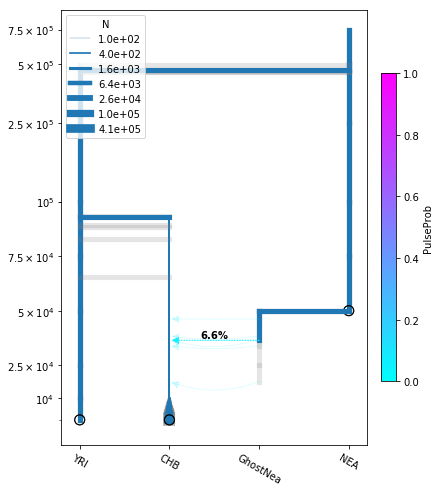

In [32]:
# make canvas, but delay plotting the demography (draw=False)
fig = momi.DemographyPlot(
    add_pulse_model, ["YRI", "CHB", "GhostNea", "NEA"],
    linthreshy=1e5, figsize=(6,8),
    major_yticks=yticks,
    draw=False)

# plot bootstraps onto the canvas in transparency
for params in bootstrap_results:
    fig.add_bootstrap(
        params,
        # alpha=0: totally transparent. alpha=1: totally opaque
        alpha=1/n_bootstraps)

# now draw the inferred demography on top of the bootstraps
fig.draw()
fig.draw_N_legend(loc="upper left") 

## Other features

### Stochastic gradient descent 

For large models, it can be useful to perform stochastic optimization:
instead of computing the full likelihood at every step,
we use a random subset of SNPs at each step to estimate
the likelihood gradient. This is especially useful for
rapidly searching for a reasonable starting point, from which
full optimization can be performed.

`DemographicModel.stochastic_optimize()` 
implements stochastic optimization with the ADAM algorithm.
Setting `svrg=n` makes the optimizer use the full likelihood
every n steps which can lead to better convergence (see the
Stochastic Variance Reduced Gradient algorithm).

The cell below performs 10 steps of stochastic optimization,
using 1000 random SNPs per step, and computing the full likelihood
every 3 iterations. 

In [33]:
add_pulse_copy.stochastic_optimize(
    snps_per_minibatch=1000, num_iters=10, svrg_epoch=3)

     fun: 3.7041955239775
     jac: array([ 2.36757200e-06, -2.36226019e-03, -1.52532277e-07, -1.46418290e-07,
        2.54764010e-02,  2.13347745e-05, -1.59764475e-08])
 message: 'Maximum number of iterations reached'
     nit: 9
 success: False
       x: array([ 1.65400741e+01, -1.00000000e-03,  8.34093634e+04,  3.69329275e+05,
       -3.76259014e+00, -1.00550759e+00, -1.22952525e+01])